# **Script para AFE**

In [ ]:
!pip install rpy2
%load_ext rpy2.ipython


In [ ]:
import pandas as pd

df = pd.read_csv("df_variables_mapeadas_AFE_vff.csv")


N observaciones usadas en el AFE: 233 
N ítems: 10 

Matriz de correlaciones policóricas (redondeada):
                                                 16_nivel_formacion_retroalimentacion
16_nivel_formacion_retroalimentacion                                             1.00
18_relevancia_retroalimentacion                                                  0.32
24_incidencia_retroalimentacion_practicas                                        0.37
25_frecuencia_tecnologias_retroalimentacion                                      0.30
29_impacto_positivo_retroalimentacion                                            0.36
30_comunidad_educativa_fomenta_retroalimentacion                                 0.27
31_retroalimentacion_integrada_formal                                            0.16
32_frecuencia_mejoras_aprendizaje                                                0.22
34_evaluacion_apoyo_institucion                                                  0.11
35_frecuencia_reportes_retroalimentac

In addition: Warning message:
In polychoric(data_afe_mat, correct = 0) :
  The items do not have an equal number of response alternatives, global set to FALSE.


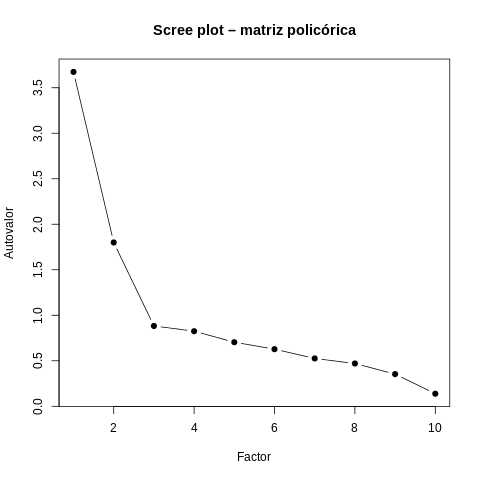

In [ ]:
%%R -i df

# Instalar paquetes de R si no están
if (!require(psych)) install.packages("psych", repos = "https://cloud.r-project.org")
library(psych)

# ================================
# 1. Seleccionar ítems del AFE
# ================================
afe_vars <- c(
  "16_nivel_formacion_retroalimentacion",
  "18_relevancia_retroalimentacion",
  #"21_tiempo_retroalimentacion_clase",
  #"22_retroalimentacion_evento_continuo",
  "24_incidencia_retroalimentacion_practicas",
  "25_frecuencia_tecnologias_retroalimentacion",
  "29_impacto_positivo_retroalimentacion",
  "30_comunidad_educativa_fomenta_retroalimentacion",
  "31_retroalimentacion_integrada_formal",
  "32_frecuencia_mejoras_aprendizaje",
  "34_evaluacion_apoyo_institucion",
  "35_frecuencia_reportes_retroalimentacion"
)

# Aseguramos que df es data.frame estándar
df <- as.data.frame(df)

data_afe <- df[ , afe_vars]

# Tratar ceros como NA
cols_zero <- c(
  "22_retroalimentacion_evento_continuo",
  "30_comunidad_educativa_fomenta_retroalimentacion",
  "31_retroalimentacion_integrada_formal"
)

for (v in cols_zero) {
  if (v %in% names(data_afe)) {
    data_afe[[v]][data_afe[[v]] == 0] <- NA
  }
}

# Eliminar filas con NA en algún ítem del AFE
data_afe <- na.omit(data_afe)

cat("N observaciones usadas en el AFE:", nrow(data_afe), "\n")
cat("N ítems:", ncol(data_afe), "\n")


# Forzar formato numérico y matricial
for (nm in names(data_afe)) {
  data_afe[[nm]] <- as.numeric(data_afe[[nm]])
}

data_afe_mat <- as.matrix(data_afe)
mode(data_afe_mat) <- "numeric"


# Matriz de correlaciones policóricas
poly_res <- polychoric(data_afe_mat, correct = 0)
R_poly   <- poly_res$rho

cat("\nMatriz de correlaciones policóricas (redondeada):\n")
print(round(R_poly, 2))

# KMO y Bartlett
kmo_res <- KMO(R_poly)
cat("\nKMO global:\n")
print(kmo_res$MSA)

cat("\nKMO por ítem:\n")
print(kmo_res$MSAi)

bart_res <- cortest.bartlett(R_poly, n = nrow(data_afe_mat))
cat("\nTest de Bartlett:\n")
print(bart_res)

# Scree plot (autovalores)
ev <- eigen(R_poly)$values
cat("\nAutovalores:\n")
print(round(ev, 3))

plot(ev, type = "b", pch = 19,
     xlab = "Factor", ylab = "Autovalor",
     main = "Scree plot – matriz policórica")


# AFE con oblimin
nf <- 2  # cambia a 1, 2 o 3

fa_res <- fa(R_poly,
             nfactors = nf,
             n.obs = nrow(data_afe_mat),
             fm = "minres",
             rotate = "oblimin")

cat("\nCargas factoriales rotadas (oblimin):\n")
print(fa_res$loadings, cutoff = 0.30, sort = TRUE)

cat("\nComunalidades:\n")
print(round(fa_res$communality, 3))

cat("\nCorrelaciones entre factores:\n")
print(round(fa_res$Phi, 3))


In [ ]:
import pandas as pd
import numpy as np

# 1. Cargar datos
# Ajusta el nombre del archivo según corresponda
df = pd.read_csv("df_variables_mapeadas_AFE_vff.csv")

# 2. Definir columnas de cada subescala
cols_IARD_P = [
    "16_nivel_formacion_retroalimentacion",
    "18_relevancia_retroalimentacion",
    "24_incidencia_retroalimentacion_practicas",
    "25_frecuencia_tecnologias_retroalimentacion",
    "29_impacto_positivo_retroalimentacion",
    "32_frecuencia_mejoras_aprendizaje"
]

cols_IARD_I = [
    "30_comunidad_educativa_fomenta_retroalimentacion",
    "31_retroalimentacion_integrada_formal",
    "34_evaluacion_apoyo_institucion",
    "35_frecuencia_reportes_retroalimentacion"
]

# 3. Reemplazar 0 (No lo sé / No aplica) por NaN en las columnas del índice
df[cols_IARD_P + cols_IARD_I] = df[cols_IARD_P + cols_IARD_I].replace(0, np.nan)

# 4. Calcular promedios de cada subescala (ignorando NaN)
df["mean_IARD_P"] = df[cols_IARD_P].mean(axis=1, skipna=True)
df["mean_IARD_I"] = df[cols_IARD_I].mean(axis=1, skipna=True)

# 5. Reescalar de 1–5 a 0–100
# Fórmula: ((promedio - 1) / (5 - 1)) * 100
df["IARD_P"] = ((df["mean_IARD_P"] - 1) / 4) * 100
df["IARD_I"] = ((df["mean_IARD_I"] - 1) / 4) * 100

# 6. Índice global = promedio simple de las dos subescalas
df["IARD_global"] = df[["IARD_P", "IARD_I"]].mean(axis=1, skipna=True)

# 7. Función para clasificar en bajo, medio, alto
def clasificar_nivel(valor):
    if pd.isna(valor):
        return np.nan
    if valor < 50:
        return "Bajo"
    elif valor < 75:
        return "Medio"
    else:
        return "Alto"

df["IARD_P_nivel"] = df["IARD_P"].apply(clasificar_nivel)
df["IARD_I_nivel"] = df["IARD_I"].apply(clasificar_nivel)
df["IARD_global_nivel"] = df["IARD_global"].apply(clasificar_nivel)

# 8. Ver algunas columnas finales
print(df[[
    "IARD_P", "IARD_P_nivel",
    "IARD_I", "IARD_I_nivel",
    "IARD_global", "IARD_global_nivel"
]].head())

# 9. (Opcional) Guardar nueva base con índices
df.to_csv("datos_retroalimentacion_con_IARD.csv", index=False)


      IARD_P IARD_P_nivel  IARD_I IARD_I_nivel  IARD_global IARD_global_nivel
0  79.166667         Alto   12.50         Bajo    45.833333              Bajo
1  58.333333        Medio   25.00         Bajo    41.666667              Bajo
2  75.000000         Alto   43.75         Bajo    59.375000             Medio
3  66.666667        Medio   56.25        Medio    61.458333             Medio
4  50.000000        Medio   25.00         Bajo    37.500000              Bajo


In [ ]:
df[[
    "16_nivel_formacion_retroalimentacion",
    "18_relevancia_retroalimentacion",
    "24_incidencia_retroalimentacion_practicas",
    "25_frecuencia_tecnologias_retroalimentacion",
    "29_impacto_positivo_retroalimentacion",
    "32_frecuencia_mejoras_aprendizaje",
    "IARD_P", "IARD_P_nivel",
    "IARD_I", "IARD_I_nivel",
    "IARD_global", "IARD_global_nivel"
]].head(10)


,16_nivel_formacion_retroalimentacion,18_relevancia_retroalimentacion,24_incidencia_retroalimentacion_practicas,25_frecuencia_tecnologias_retroalimentacion,29_impacto_positivo_retroalimentacion,32_frecuencia_mejoras_aprendizaje,IARD_P,IARD_P_nivel,IARD_I,IARD_I_nivel,IARD_global,IARD_global_nivel
0,5,4,5,2,5,4,79.166667,Alto,12.50,Bajo,45.833333,Bajo
1,3,3,4,2,4,4,58.333333,Medio,25.00,Bajo,41.666667,Bajo
2,3,4,4,4,5,4,75.000000,Alto,43.75,Bajo,59.375000,Medio
3,5,5,4,1,4,3,66.666667,Medio,56.25,Medio,61.458333,Medio
4,3,2,3,2,4,4,50.000000,Medio,25.00,Bajo,37.500000,Bajo
5,5,5,5,3,5,4,87.500000,Alto,37.50,Bajo,62.500000,Medio
6,4,4,4,1,4,3,58.333333,Medio,12.50,Bajo,35.416667,Bajo
7,4,4,4,2,5,4,70.833333,Medio,31.25,Bajo,51.041667,Medio
8,3,5,4,3,5,4,75.000000,Alto,37.50,Bajo,56.250000,Medio
9,5,4,5,3,4,3,75.000000,Alto,25.00,Bajo,50.000000,Medio


In [ ]:
df[["IARD_P", "IARD_I", "IARD_global"]].describe()


,IARD_P,IARD_I,IARD_global
count,260.000000,260.000000,260.000000
mean,72.692308,32.155449,52.423878
std,13.054122,16.757859,12.131460
min,33.333333,0.000000,22.916667
25%,62.500000,18.750000,43.750000
50%,75.000000,31.250000,52.083333
75%,83.333333,43.750000,61.458333
max,100.000000,75.000000,84.375000


In [ ]:
import pandas as pd
import numpy as np

# 1. Definir columnas de cada subescala (mismos nombres del AFE)
cols_IARD_P = [
    "16_nivel_formacion_retroalimentacion",
    "18_relevancia_retroalimentacion",
    "24_incidencia_retroalimentacion_practicas",
    "25_frecuencia_tecnologias_retroalimentacion",
    "29_impacto_positivo_retroalimentacion",
    "32_frecuencia_mejoras_aprendizaje"
]

cols_IARD_I = [
    "30_comunidad_educativa_fomenta_retroalimentacion",
    "31_retroalimentacion_integrada_formal",
    "34_evaluacion_apoyo_institucion",
    "35_frecuencia_reportes_retroalimentacion"
]

cols_IARD_10 = cols_IARD_P + cols_IARD_I


# 2. Función para calcular alfa de Cronbach
def cronbach_alpha(df_items):
    """
    df_items: DataFrame con solo las columnas (ítems) a analizar.
    Devuelve el alfa de Cronbach.
    """
    # Eliminar filas con NA en esos ítems (casos completos)
    df_clean = df_items.dropna()
    k = df_clean.shape[1]  # número de ítems

    if k < 2:
        return np.nan

    # Varianza de cada ítem
    item_vars = df_clean.var(axis=0, ddof=1)
    # Varianza de la suma total
    total_var = df_clean.sum(axis=1).var(ddof=1)

    alpha = (k / (k - 1)) * (1 - item_vars.sum() / total_var)
    return alpha


# 3. Asegurar que los 0 (= No lo sé / No aplica) sean NaN en estos ítems
df[cols_IARD_10] = df[cols_IARD_10].replace(0, np.nan)

# 4. Calcular alfa para cada subescala y para los 10 ítems
alpha_P = cronbach_alpha(df[cols_IARD_P])
alpha_I = cronbach_alpha(df[cols_IARD_I])
alpha_total = cronbach_alpha(df[cols_IARD_10])

print("α Cronbach IARD-P (Práctica y valoración, 6 ítems):", round(alpha_P, 3))
print("α Cronbach IARD-I (Institucionalización y apoyo, 4 ítems):", round(alpha_I, 3))
print("α Cronbach total (10 ítems):", round(alpha_total, 3))


α Cronbach IARD-P (Práctica y valoración, 6 ítems): 0.69
α Cronbach IARD-I (Institucionalización y apoyo, 4 ítems): 0.732
α Cronbach total (10 ítems): 0.738
